In [28]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import random
import pandas as pd
import glob
import matplotlib.pyplot as plt
import specmatchemp.library
import specmatchemp.plots as smplot
from scipy.integrate import trapz
from scipy.constants import pi, h, c, k
from pandas.api.types import CategoricalDtype
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import CustomJS, Button
from bokeh.layouts import row, column

h*=1e7 # Planck constant in erg*s
c*=1e2 # light speed in cm/s
k*=1e7 # Boltzmann constant in erg/K

def dprint(str,debug):
    
    '''
    Prints out all help text snippets where the debug flag is passed.
    '''
    
    if debug==True:
        print(str)
    return

def display(opt,d,debug):
    
    '''
    Displays additional information about a resulting 
    combo _opt_ of spectral classes given some colors 
    and approximates their likelihood by the mutual distance
    between the rows _d_. Conditional on the _debug_ flag being passed.
    '''
    
    dprint('New combination: {}'.format(opt),debug)
    dprint('This combination has distance {}'.format(d),debug)
    
    return

def spec_class_hist(specs,cluster,sort):

    counts = specs.spec_class.value_counts(sort=False)
    y = counts.sort_index()
    plot = y.plot(kind = 'bar',color='blue')
    fig = plot.get_figure()
    fig.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/clean_CMD_{}.jpg'.format(cluster),dpi=300)
    return

def CMD(specs,cluster,cid1='gmag',cid2='imag',color='g_i',ylim=(19,5),outliers=pd.Series()):
    '''
    Plots and saves CMDs for specified bands, 
    marks outliers if any are passed.
    '''
    specs[color]=specs[cid1]-specs[cid2]
    plot = specs.plot(x=color,y=cid1,ylim=ylim,kind = 'scatter', color=color_outlier_red(specs.EPIC,outliers))
    fig = plot.get_figure()
    fig.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/CMD_{}_{}.jpg'.format(cluster,color),dpi=300)
    return

def color_outlier_red(val,outliers):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color=[]
    for id_ in val:
        if id_ in list(outliers):
            color.append('red')
        else:
            color.append('black')
    #color = ['red' if val in outliers else 'black'
    return color


def interactive_CMD(specs,cid1='gmag',cid2='imag'):
    '''
    Simplistic tool to create an interactive 
    bokeh plot where outliers can be marked and saved in
    '/home/ekaterina/Documents/appaloosa/stars_shortlist/share/temp'
    '''
    # Create some random data and put it into a ColumnDataSource
    x = list(specs[cid1]-specs[cid2])
    y = list(specs[cid2])
    z = list(specs.EPIC)
    source_data = ColumnDataSource(data=dict(x=x, y=y,desc=z))
    
    # Create a button that saves the coordinates of selected data points to a file
    savebutton = Button(label="Save", button_type="success")
    savebutton.callback = CustomJS(args=dict(source_data=source_data), code="""
            var inds = source_data.selected['1d'].indices;
            var data = source_data.data;
            var out = "";
            for (i = 0; i < inds.length; i++) {
                out += data['desc'][inds[i]] + " ";
            }
            var file = new Blob([out], {type: 'text/plain'});
            var elem = window.document.createElement('a');
            elem.href = window.URL.createObjectURL(file);
            elem.download = 'selected-data.txt';
            document.body.appendChild(elem);
            elem.click();
            document.body.removeChild(elem);
            """)

    # Plot the data and save the html file
    p = figure(plot_width=800, plot_height=400, 
               y_range=(16,7),
               tools="lasso_select, reset",)
    p.circle(x='x', y='y', source=source_data)
    p.xaxis.axis_label = '{}-{}'.format(cid1[0],cid2[0])
    p.yaxis.axis_label = cid1[0]
    plot = column(p, savebutton)
    output_file("test.html")
    show(plot)
    return

#----------------------------------------
#ENERGY CALC
#---------------------------------------

#Solution to nan-bug:
#https://stackoverflow.com/questions/6518811/interpolate-nan-values-in-a-numpy-array

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def interpolate_nan(y):
    nans, x= nan_helper(y)
    y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    return

#End: Solution to nan_bug

def spectrum(T, lib, wavmin=3480., wavmax=9700.:
    
    '''
    
    Returns the spectrum of a star at effective temperature T in wavelength range [wavmin,wavmax]
    Default range corresponds to Kepler response
    
    '''
    #loads library of spectra within wavelength range
    
    if T > 7000:
        print('{}K is hotter than 7000K.'.format(T))
        return lib.wav, []
    elif T < 3000:
        print('{}K is cooler than 3000K.'.format(T))
        return lib.wav, []
    else: 

        #find the spectrum that fits T best
        print('T=',T)
        Tmin = str(T-100.)
        Tmax = str(T+100.)
        cut = lib.library_params.query(Tmin+'<Teff<'+Tmax)
        #print('cut\n',cut.head())
        T_offer = zip(list(cut['Teff']), list(cut['lib_index']))
        T_minindex = min(T_offer, key = lambda t: abs(t[0]-T))[1]
        cut = cut.loc[T_minindex]
        #return the spectrum
        spec = lib.library_spectra[cut.lib_index,0,:]
        return lib.wav, spec.T

def kepler_spectrum(T,lib):
    '''
    
    Convolves a blackbody of effective temperature T, 
    the spectrum of a dwarf star with corresponding spectral class,
    and the Kepler response function 
    to return the wavelength dependent flux of that star per area
    
    Parameters:
    -----------
    T - effective temperatur in K
    
    Returns:
    --------
    Kp_flux in erg/cm*(cm**2)
    Kp_midwav in angström
    
    
    '''
    Kp = pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/static/Kepler_response.txt',
                                  skiprows=9,
                                  header=None,
                                  delimiter='\t',
                                  names=['wav','resp'])
    Kp.wav = Kp.wav.astype(np.float)*10. #convert to angström for spectrum function
    #load the spectrum within a wavelength range that fits given T_eff best
    Spec_wav, Spec_flux = spectrum(T,lib,Kp.wav.min(),Kp.wav.max())
    #map Kepler response linearly into wavelengths given with the spectrum
    if Spec_flux == []:
        print('{}K is too hot or too cool for specmatch-emp.'.format(T))
        return [],[],[]
    else:
        Spec_flux = np.interp(Kp.wav,Spec_wav,Spec_flux)
        Kp_flux = np.empty(Kp.wav.shape[0]-1)
        Kp_midwav  = np.empty(Kp.wav.shape[0]-1)
        planck  = np.empty(Kp.wav.shape[0]-1)
        #calculate the flux of a star with given T_eff 
        #accounting for Kepler filter 
        #and the corresp. spectrum of that stellar type 
        try:
            for i, response in Kp.resp[:-1].iteritems():
                dlambda = (Kp.wav[i+1]-Kp.wav[i])*1e-8 #infin. element of wavelength in cm
                lambda_ = Kp.wav[i:i+2].mean()*1e-8 #wavelength in cm
                Kp_midwav[i] = lambda_
                planck[i] = 2. * h * c**2 / lambda_**5 / (np.exp( h * c / ( lambda_ * k * T ) ) - 1. )     
                Kp_flux[i] = Spec_flux[i] * response * planck[i]
        except IndexError:
            pass
        
        return Kp_midwav, Kp_flux, planck

def plot_kepler_spectrum(T):

    wav, flux, planck = kepler_spectrum(T,lib)
    
    Kp = pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/static/Kepler_response.txt',
                                  skiprows=9,
                                  header=None,
                                  delimiter='\t',
                                  names=['wav','resp'])

    if flux == []:
        return print('No data for T = {}K'.format(T))
    else:
        plt.figure()
        plt.plot(wav*1e8, flux,color='green')
        plt.plot(wav*1e8, Kp.resp[:-1]*planck.max(),color='red')
        plt.plot(wav*1e8, planck,color='black')
        plt.show()  
    return

def kepler_luminosity(T,lib):
    
    '''
    Integrates the Kepler flux,
    multiplies by the area A=pi*(R**2),
    to obtain observed quiescent flux for an object
    
    Return:
    
    total Kepler luminosity in erg/s of a dwarf star with effective temperature T
    
    '''
    
    params=pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/static/merged_specs.csv')
    
    #calculate Kepler spectrum of a dwarf star with temperature T
    print(T)
    wav, flux, _ = kepler_spectrum(T,lib)
    
    if flux == []:
        return print('{}K is too hot or too cold'.format(T))
    else:
        #interpolate where nans occur
        interpolate_nan(wav)
        interpolate_nan(flux)

        #select the relevant columns from params
        radii_teff = params[['T','R_Rsun']]
        radii_teff.set_index('T',inplace=True)
        radius_cm = radii_teff.R_Rsun[T]*6.96342e10 #stellar radius in cm
        return np.trapz(flux, wav) * pi * (radius_cm**2)

    
def Kp_to_Lum(df, dm, Kp='Kp'):
    df['Kp_abs'] = df[Kp]+dm
    #print(df.head())
    return

def Mbol_to_Lum(Mbol):
    
    '''
    Returns:
    --------
    Bolometric luminosity of a star with Mbol in erg/s.
    '''
    
    Lum_Sun = 3.84e33 #erg/s
    Mbol_Sun = 4.74 #mag
    return Lum_Sun * 10**( Mbol_Sun - Mbol )

#-------------------------------
#FFD
#-------------------------------

def ED(start,stop,time,flux_model,flux_gap):
    start, stop = int(start),int(stop)
    time = np.asarray(time)[start:stop+1]
    model = np.asarray(flux_model)[start:stop+1]
    flux = np.asarray(flux_gap)[start:stop+1]
    residual = np.subtract(flux,model)
    flare = trapz(residual,time)
    quiet = trapz(model,time)
    ed = flare/quiet
    return ed


def import_flares(cluster, test, oid):
    
    objectid = str(oid)
    loc = '/home/ekaterina/Documents/appaloosa/stars_shortlist/{}/results/{}'.format(cluster,test)
    myloc = loc + '_my_flares.txt'
    try:
        myflares = pd.read_csv(myloc, names= ['start','stop','istart','istop','comment'])
    except OSError:
        myflares = []

    appaflares = pd.read_csv('{}/{}_flux.csv'.format(loc,oid))#, names= ['time','flux_gap','error','flux_model'])
    appaids = pd.read_csv('{}/{}_flares.csv'.format(loc,oid))#, names= ['istart','istop'])
    return myflares, appaflares, appaids


def cum_hist(flares, flux, L_quiet,bins=5):
    ED_=[]
    s_s = flares[['istart_no_sys_no_thruster','istop_no_sys_no_thruster']]
    s_s = s_s.dropna()
    for i,row in s_s.iterrows():
        #print(row['istart'])
        #ed = ED(row['istart'],row['istop'],flux.time,flux.flux_model,flux.flux_gap)
        ed = ED(row['istart_no_sys_no_thruster'],row['istop_no_sys_no_thruster'],flux.time,flux.flux_model,flux.flux_gap)
        if (ed != 'nan') & (ed >0):
            ED_.append(np.log10(ed*24.*60.*60.*L_quiet))
    
    #print(ED_)
    #ED_ = np.asarray(ED_)
    #ED_ = ED_.dropna()
    hist, edges=np.histogram(ED_, bins=bins)

    hist = np.flip(np.cumsum(np.flip(hist,axis=0)),axis=0)

    return hist, edges

def merged_spec_class(params):
    p = pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/static/merged_specs.csv')
    colors = {'g_r':('gmag','rmag'),
              'r_i':('rmag','imag'),
              'i_z':('imag','zmag'),
              'z_J':('zmag','J'),
              'J_H':('J','H'),
              'H_K':('H','K'),
              'i-z':('imag','zmag'),
              'z-Y':('zmag','ymag'),
              'J-H':('J','H'),
              'H-K':('H','K'),}
    for col in p.columns.values:
        params[col]=np.nan
    for i, s in params.iterrows():
        _ = np.array([((s[item[0]]-s[item[1]])-p[key]).abs().argmin() for key, item in colors.items()])
        idx = np.int(np.median(_[~np.isnan(_)]))    
        for col in p.columns.values:
            params[col][i]=p[col].iloc[idx]

    params = params.join(p.iloc[idx])    
    return params

DM = lambda x: 5.*np.log10(float(x))-5. 

Reading library from /home/ekaterina/.specmatchemp/library.h5


## Load parameters and calculate quiescent luminosity, assign spectral class and  if not already

In [9]:
cluster_dict = {'M67':['M67','M67', 15, 4.0, 850],
                'Ruprecht_147':['Ruprecht 147','Ruprecht_147', 30, 2.5, 300.],
                'M44':['M44','M44', 47, 0.73, 181.5],
                'M45':['M45','M45',55.,0.12,120.],
                'NGC_1647':['NGC 1647','NGC_1647',0.,0.145,550.],
                'Pleiades':['Pleiades','Pleiades',0.,0.100,136.]
               }

cluster = 'NGC_1647'
basics = cluster_dict[cluster]
global dm = DM(basics[4])
l = '/home/ekaterina/Documents/appaloosa/stars_shortlist/{0}/{0}_parameter.csv'.format(cluster)

print(glob.glob(l))

if glob.glob(l) != []:
    specs = pd.read_csv(l, index_col='EPIC')
else:
    wavmin, wavmax = 3480., 9700.
    lib = specmatchemp.library.read_hdf(wavlim=[wavmin,wavmax])
    specs = merged_spec_class(params)
    specs['L_quiet'] = np.nan
    specs['L_quiet_bol'] = np.nan
    for oid in specs.index.values:
        specs.L_quiet_bol[oid] = Mbol_to_Lum(specs.Mbol[oid])
        specs.L_quiet[oid] = kepler_luminosity(specs['T'][oid],lib)
        #plot_kepler_spectrum(specs['T'][oid])
        
specs[['T','L_quiet','L_quiet2']].sort_values(by='T').head()

In [ ]:
crs = {'g_i':('gmag','imag'),
       'J_K':('J','K'),
       'r_z':('rmag','zmag'),
       'g_z':('gmag','zmag'),}

for key, c in crs.items():
    print(c[0],c[1])
    interactive_CMD(specs,cid1=c[0],cid2=c[1])
    input('Plot for {} done?'.format(key))

In [ ]:
outs=pd.Series()
for i in range(4):
    df = pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/temp/selected-data{}.txt'.format(i),header=None,sep=' ').T.dropna(how='any')
    df = df.rename(index=str, columns={0:'outlier'})
    df.outlier = df.outlier.astype('int')
    s = df.outlier
    outs = pd.concat([outs,s],ignore_index=True)
outs = outs.drop_duplicates()
print(outs)
for key, c in crs.items():
    CMD(specs,cluster,cid1=c[0],cid2=c[1],color=key,ylim=(19,5),outliers=outs)
outs.to_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/{0}/{0}_outliers.csv'.format(cluster))

In [14]:
print(specs.shape)
specs = specs.drop(list(outs))
print(specs.shape)

(94, 53)
0    247154299
1    247153146
2    247169098
3    247153504
5    247168106
6    247153094
Name: ID, dtype: int64
(88, 53)


In [16]:
specs = specs.dropna(how='any',subset=['T','L_quiet'])
print(specs.shape)

(88, 53)


In [17]:
#intermediate save
specs.to_csv(l)

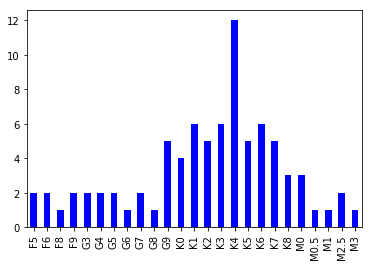

In [25]:
categor = ['{}{}'.format(c,num) for c in list('OBAFGKM') for num in list(range(10))]
type_ = CategoricalDtype(categories=categor, ordered=True)
specs.spec_class.astype(type_)
s = specs.sort_values(by='spec_class')
spec_class_hist(s,cluster,type_)

In [26]:
#remove all objects with spectral class hotter than F4
specs = specs[specs.spec_class > 'F3']
specs.shape

(82, 57)

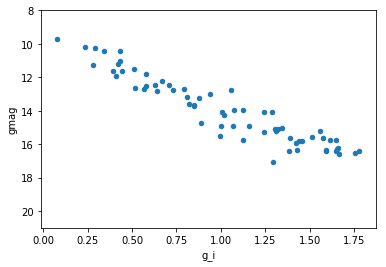

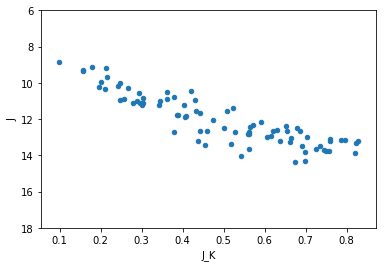

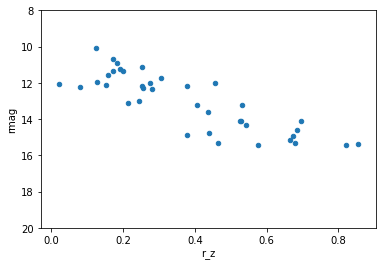

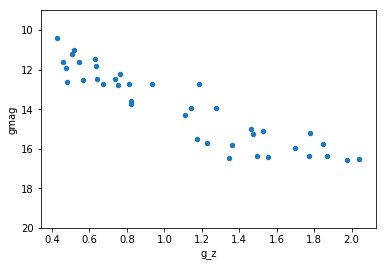

In [27]:
CMD(specs,cluster,cid1='gmag',cid2='imag',color='g_i',ylim=(21,8))#19,5
CMD(specs,cluster,cid1='J',cid2='K',color='J_K',ylim=(18,6))#14,5
CMD(specs,cluster,cid1='rmag',cid2='zmag',color='r_z',ylim=(20,8))#18,5
CMD(specs,cluster,cid1='gmag',cid2='zmag',color='g_z',ylim=(20,9))#18,5

In [ ]:
def FFD(oid, cluster, test, specs,color='red'):
    myflares, flux, flares = import_flares(cluster, test, oid)
    bsc = specs.spec_class.loc[oid]
    #    best_spec_class = optimize_spec_class_ID(oid,params,tab_spec)
    T = specs['T'].loc[oid]
    L_quiet = specs['L_quiet'].loc[oid]
    histAppa, edgesAppa = cum_hist(flares, flux, L_quiet,bins=5)
    binmids=[(x+edgesAppa[i])/2. for i,x in enumerate(edgesAppa[1:])]
    return plt.plot(binmids[1:],np.log10(histAppa[1:]),color=color,alpha=0.8,label='EPIC {}, T={}K'.format(oid,T))

def cum_hist_average(oid_list, cluster, test, specs):
    ED_, bins=[], 600
    for oid in oid_list:

        myflares, flux, flares = import_flares(cluster, test, oid)
       
        bsc = specs.spec_class.loc[oid]
   
        T = specs['T'].loc[oid]
        L_quiet = specs['L_quiet'].loc[oid]
        s_s = flares[['istart_no_sys_no_thruster','istop_no_sys_no_thruster']].dropna()
        for i,row in s_s.iterrows():
            ed = ED(row['istart_no_sys_no_thruster'],row['istop_no_sys_no_thruster'],flux.time,flux.flux_model,flux.flux_gap)
            if (ed != 'nan') & (ed >0):
                ED_.append(np.log10(ed*24.*60.*60.*L_quiet))
    
    hist, edges=np.histogram(ED_, bins=bins)
    hist = np.flip(np.cumsum(np.flip(hist/oid_list.shape[0],axis=0)),axis=0)
    return hist, edges

def FFD_average(specs, cluster, test,class_='K7',color='red'):
    select = np.asarray([i for sublist in [specs[specs.spec_class.str.contains(c)].index.values for c in class_] for i in sublist])
    left, right = 250, -160
    #select = specs[specs.spec_class.str.contains(class_)].index.values
    hist, edges = cum_hist_average(select, cluster, test, specs)
    binmids=[(x+edges[i])/2. for i,x in enumerate(edges[1:])]
    p,residuals, rank, singular_values, rcond= np.polyfit(x=binmids[left:right],y=np.log10(hist[left:right]),deg=1, full=True)
    print(p,residuals, rank, singular_values, rcond)
    plt.plot(binmids, p[0]*np.asarray(binmids)+p[1])
    plt.axvline(x=binmids[left])
    plt.axvline(x=binmids[right])
    plt.plot(binmids,np.log10(hist),color=color,alpha=0.8,label='{}, n={}'.format(tuple(class_),len(select)))
    return p, left, right, binmids


plt.figure(figsize=(12,8))
plt.title('Cumulative FFD: {}, {}'.format(cluster,test))
#FFD_average(specs, cluster, test,class_=['K','M'],color='orange')
#FFD_average(specs, cluster, test,class_=['G'],color='green')
#FFD_average(specs, cluster, test,class_=['F'],color='blue')
#c_ = ['K','M']
#c_ = 'G'
#c_ = 'F'
c_ = ['F','G','K','M']
p,left, right, binmids = FFD_average(specs, cluster, test,class_=list(c_),color='black')
plt.legend()
plt.xlabel('log(energy in erg)')
plt.ylabel('log(frequency)')
if c_==['']: c_='all'
elif type(c_) == list: c_ = ''.join(map(str, c_))
plt.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/{0}/results/{1}/plots/{0}_{1}_cum_FFD_{2}.jpg'.format(cluster,test,c_))


In [ ]:
if c_==['']: c_='all'
elif type(c_) == list: c_ = ''.join(map(str, c_))
print(c_)
columns = ['run','cluster','class','alpha','beta','cut_left','cut_right']
d = dict(zip(columns,[[test], [cluster],[c_],[-p[0]], [p[1]],[binmids[left]],[binmids[right]]]))
#tab = pd.DataFrame(d)
#tab = tab[columns]
tab = pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/compare_alpha.csv')#,index_col=0)
#print(tab)
#d = dict(zip(columns,[[test], [cluster],[c_],[-p[0]], [p[1]],[binmids[left]],[binmids[right]]]))
#tab = tab.append(pd.DataFrame(d))#,columns=columns)
#print(tab)
#tab.to_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/compare_alpha.csv')
tab

In [ ]:
import math
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx
    
cluster = 'M67'
info = pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/{}/results/tests.csv'.format(cluster))
class_ = 'FGKM'
r = tab[(tab['class'] == class_) & ((tab.run == 'run_06') | (tab.run == 'run_07') | (tab.run == 'run_04'))].sort_values(by='cluster')
plt.figure(figsize=(12,8))
plt.title('FFD power law fits to M67 and M44 for spectral class {}'.format(class_))

plt.xlabel('log(energy in erg)')
plt.ylabel('log(frequency)')
cc = {'M44':'blue','M67':'red'}
x = np.arange(31,36,0.05)
for idx, row in r.iterrows():
    iid = int(row.run[5:])-1
    l = find_nearest(x,row.cut_left)
    r = find_nearest(x,row.cut_right)
    plt.plot(x[l:r], 
             -row.alpha*x[l:r]+row.beta, 
             label='{}, N1 = {}, N2 = {}, N3 = {}, {}'.format(row.cluster, info.N1.loc[iid], info.N2.loc[iid], info.N3.loc[iid], info.other.loc[iid]),
             color=cc[row.cluster], alpha = float(row.run[5:])/4)
plt.legend()
#plt.savefig('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/fits_{}_{}_comparison.jpg'.format(cluster,class_,))


In [ ]:
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color


piv = pd.pivot_table(tab, values='alpha', index=['class','run'], columns=['cluster'])#, aggfunc=np.sum)
piv['M44-M67']=piv.M44-piv.M67
piv.style.applymap(color_negative_red)